# **Deep learning for image analysis with Python**

#### Fernando Cervantes, Systems Analyst I, Imaging Solutions, Research IT
#### fernando.cervantes@jax.org    (slack) @fernando.cervantes

## **3 Implement a deep neural network**

## 3.1 _Neural network modules_

PyTorch provides several operations that can be used as building blocks to construct a neural network.<br>
Each operation is commonly referred as a **Module**, and those are implemented inside the *nn* module of pytorch.

![Image](https://pytorch.org/tutorials/_images/mnist.png)

### 3.1.1 What are convolutions

- First, images can be considered as functions. In the case of two dimensions an image is a function $F: (x, y) \mapsto I$, where $x, y \in \mathbb{R}$, and $I \in \mathbb{R}^3$, for RGB images, or $I \in \mathbb{R}$ for grayscale images.<br>
- Second, image functions can be _digitized_ into a digital signal that can be stored in a computer.<br>

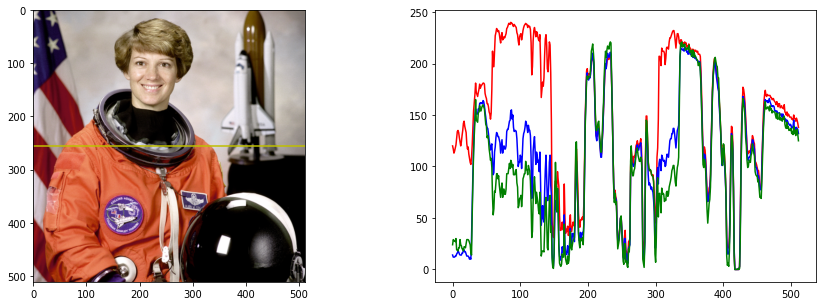

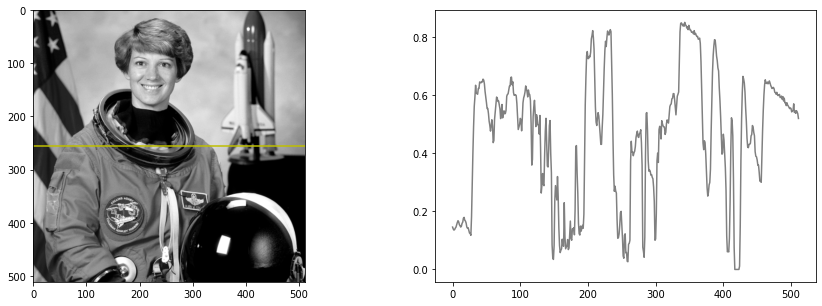

In [4]:
import torch
import matplotlib.pyplot as plt
from skimage.data import astronaut
from skimage.color import rgb2gray

plt.rcParams['figure.figsize'] = [15, 5]

im = astronaut()

h, w, _ = im.shape

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.plot([-0.5, w-0.5], [h/2, h/2], "y")
plt.subplot(1, 2, 2)
plt.plot(im[h//2, :, 0], "r")
plt.plot(im[h//2, :, 1], "b")
plt.plot(im[h//2, :, 2], "g")
plt.show()

im_gray = rgb2gray(im)

plt.subplot(1, 2, 1)
plt.imshow(im_gray, cmap='gray')
plt.plot([-0.5, w-0.5], [h/2, h/2], "y")
plt.subplot(1, 2, 2)
plt.plot(im_gray[h//2, :], c='0.5')
plt.show()

Convolutions are linear transforms that can be applied to a function. This linear transform computes the inner product between two functions (the input and a kernel) over the input domain.<br>
When applied to digital (discrete) signals, the inner product is changed by a linear combination (sum). <br>
### $R(x, y) = \sum\limits_{u, v} I(x-u, y-v)  k(u,v)$ <br>

Lets try a one-dimensional convolution on the profile we got from the image above

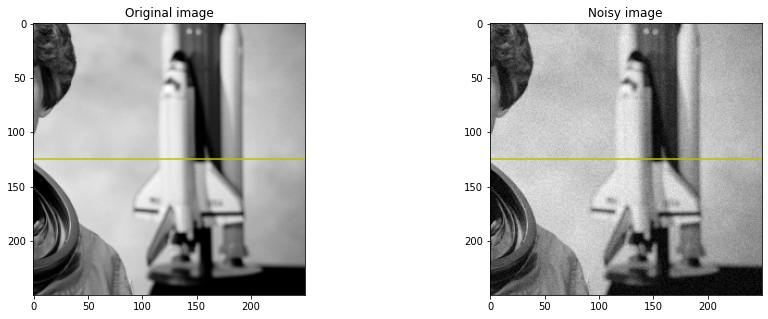

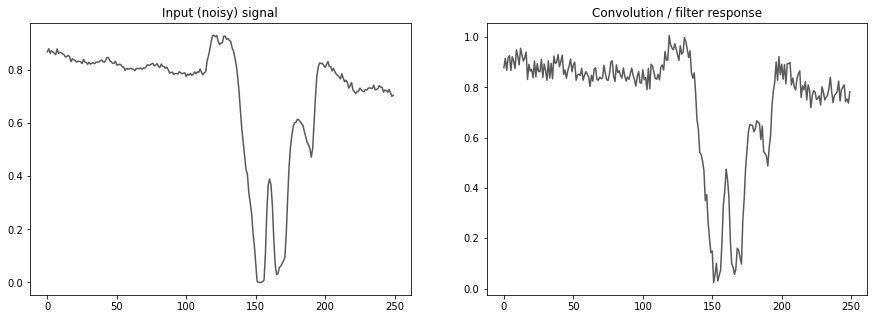

In [6]:
import torch.nn.functional as F

im_gray = rgb2gray(astronaut()[50:300, -250:, :])

h, w = im_gray.shape

x_gray = torch.from_numpy(im_gray).float() + 0.1 * torch.rand(im_gray.shape)

plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(im_gray, cmap='gray')
plt.plot([-0.5, w-0.5], [h/2, h/2], "y")
plt.subplot(1, 2, 2)
plt.title('Noisy image')
plt.imshow(x_gray, cmap='gray')
plt.plot([-0.5, w-0.5], [h/2, h/2], "y")
plt.show()

plt.subplot(1, 2, 1)
plt.plot(im_gray[h//2, :], c='0.35')
plt.title('Input (noisy) signal')
plt.subplot(1, 2, 2)
plt.plot(x_gray[h//2, :], c='0.35')
plt.title('Convolution / filter response')
plt.show()

In [7]:
kernel = torch.FloatTensor(
    [0, 0, 1, 1, 1, 1, 1, 0, 0]
)

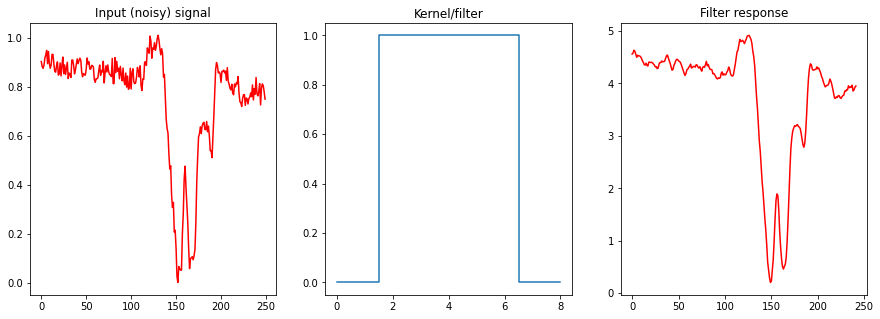

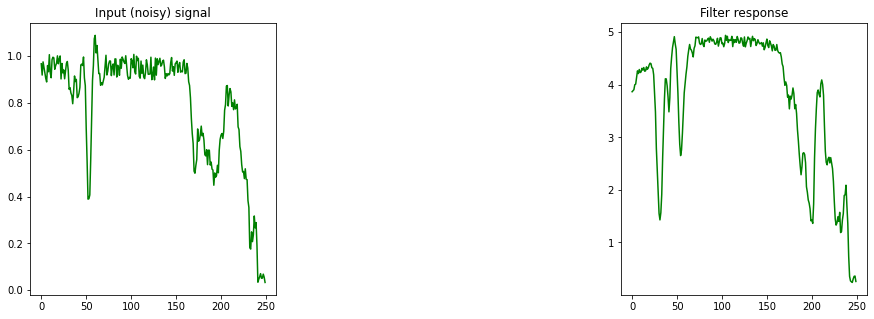

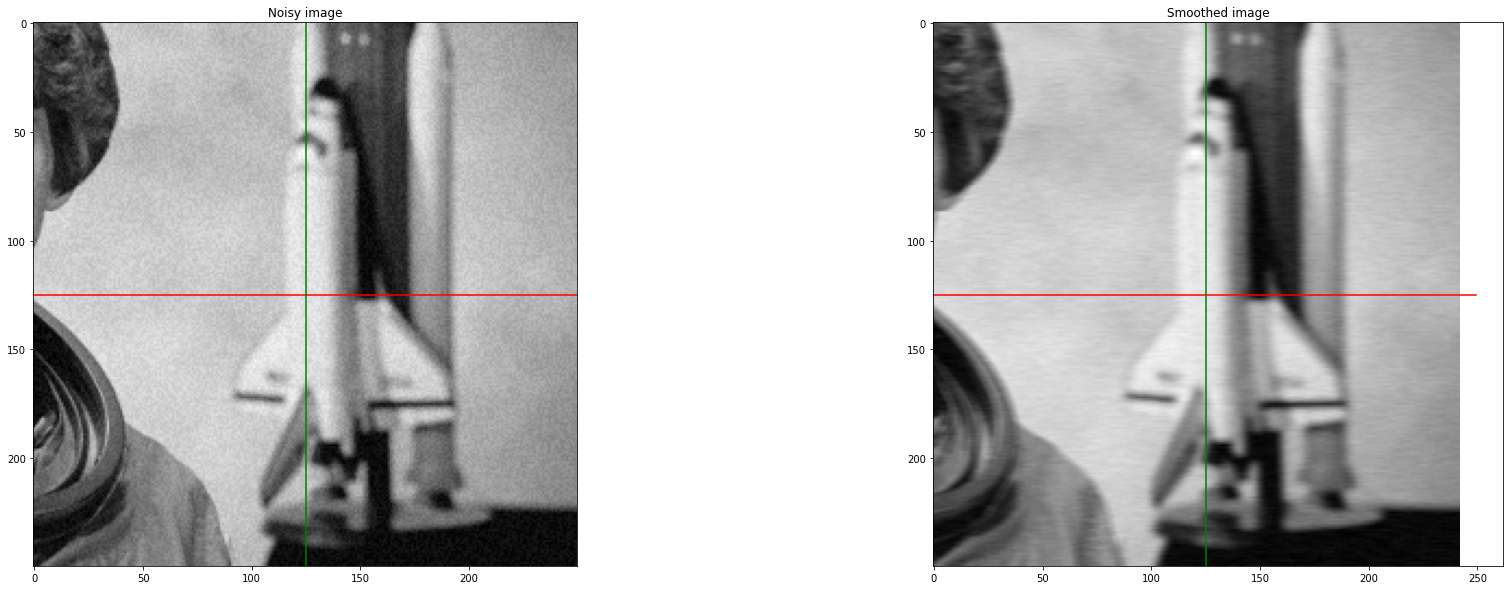

In [8]:
import torch.nn.functional as F

h, w = im_gray.shape
k_h, k_w = 1, kernel.shape[0]

x_gray = torch.from_numpy(im_gray).float() + 0.1 * torch.rand(im_gray.shape)
x_smooth = F.conv2d(x_gray.view(1, 1, h, w), kernel.view(1, 1, k_h, k_w)).squeeze()

plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(1, 3, 2)
plt.plot(kernel.squeeze(), drawstyle='steps-mid')
plt.title('Kernel/filter')
plt.subplot(1, 3, 1)
plt.plot(x_gray[h//2, :], 'r')
plt.title('Input (noisy) signal')
plt.subplot(1, 3, 3)
plt.plot(x_smooth[h//2, :], 'r')
plt.title('Filter response')
plt.show()

plt.subplot(1, 3, 1)
plt.plot(x_gray[:, w//2], 'g')
plt.title('Input (noisy) signal')
plt.subplot(1, 3, 3)
plt.plot(x_smooth[:, w//2], 'g')
plt.title('Filter response')
plt.show()


plt.rcParams['figure.figsize'] = [30, 10]

plt.subplot(1, 2, 1)
plt.title('Noisy image')
plt.imshow(x_gray, cmap='gray')
plt.plot([-0.5, w-0.5], [h/2, h/2], "r")
plt.plot([w/2, w/2], [-0.5, h-0.5], "g")
plt.subplot(1, 2, 2)
plt.title('Smoothed image')
plt.imshow(x_smooth, cmap='gray')
plt.plot([-0.5, w-0.5], [h/2, h/2], "r")
plt.plot([w/2, w/2], [-0.5, h-0.5], "g")
plt.show()


In [9]:
kernel = torch.FloatTensor([
    [0],
    [0],
    [1],
    [1],
    [1],
    [1],
    [1],
    [0],
    [0]]
)

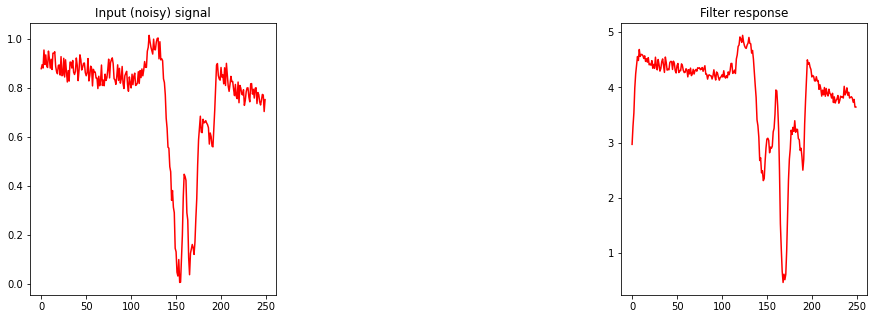

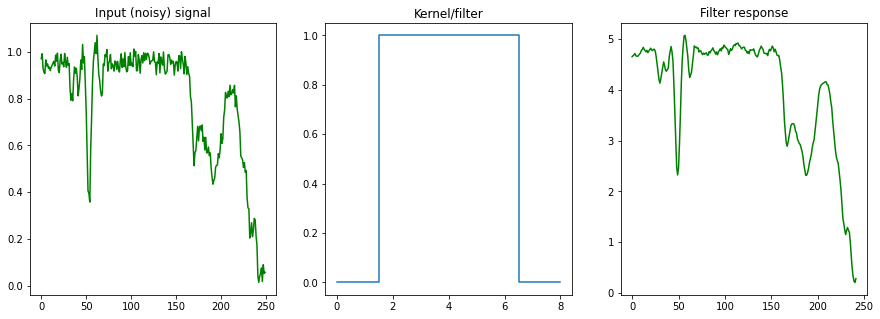

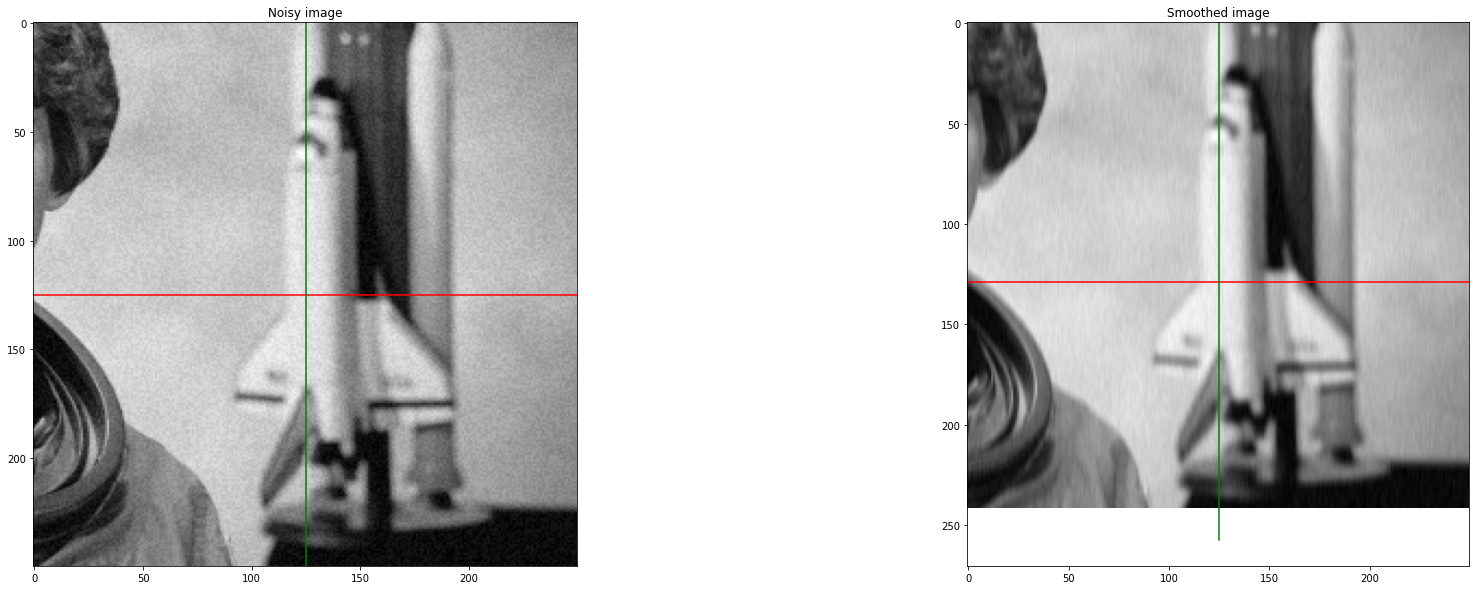

In [10]:
import torch.nn.functional as F

h, w = im_gray.shape
k_h, k_w = kernel.shape

x_gray = torch.from_numpy(im_gray).float() + 0.1 * torch.rand(im_gray.shape)
x_smooth = F.conv2d(x_gray.view(1, 1, h, w), kernel.view(1, 1, k_h, k_w)).squeeze()

plt.rcParams['figure.figsize'] = [15, 5]

plt.subplot(1, 3, 1)
plt.plot(x_gray[h//2, :], 'r')
plt.title('Input (noisy) signal')
plt.subplot(1, 3, 3)
plt.plot(x_smooth[h//2, :], 'r')
plt.title('Filter response')
plt.show()

plt.subplot(1, 3, 2)
plt.plot(kernel.squeeze(), drawstyle='steps-mid')
plt.title('Kernel/filter')
plt.subplot(1, 3, 1)
plt.plot(x_gray[:, w//2], 'g')
plt.title('Input (noisy) signal')
plt.subplot(1, 3, 3)
plt.plot(x_smooth[:, w//2], 'g')
plt.title('Filter response')
plt.show()


plt.rcParams['figure.figsize'] = [30, 10]

plt.subplot(1, 2, 1)
plt.title('Noisy image')
plt.imshow(x_gray, cmap='gray')
plt.plot([-0.5, w-0.5], [h/2, h/2], "r")
plt.plot([w/2, w/2], [-0.5, h-0.5], "g")
plt.subplot(1, 2, 2)
plt.title('Smoothed image')
plt.imshow(x_smooth, cmap='gray')
plt.plot([-0.5, (w+k_w-1)-0.5], [(h+k_h-1)/2, (h+k_h-1)/2], "r")
plt.plot([(w+k_w-1)/2, (w+k_w-1)/2], [-0.5, (h+k_h-1)-0.5], "g")
plt.show()

Lets see a convolution using a two-dimensional _kernel_ of size 3$\times$3 in action!

In [11]:
kernel = torch.ones(5, 5)
print(kernel)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


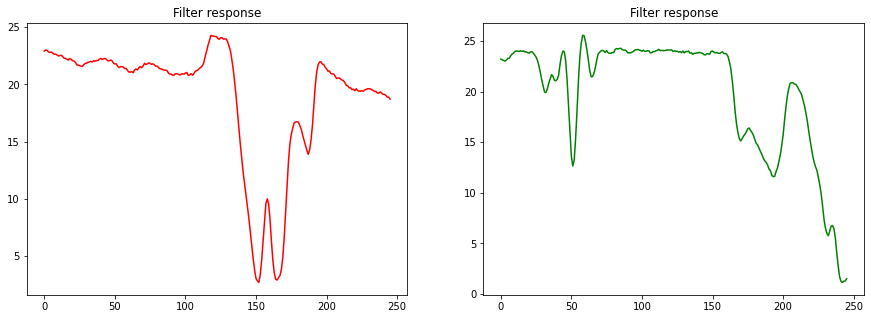

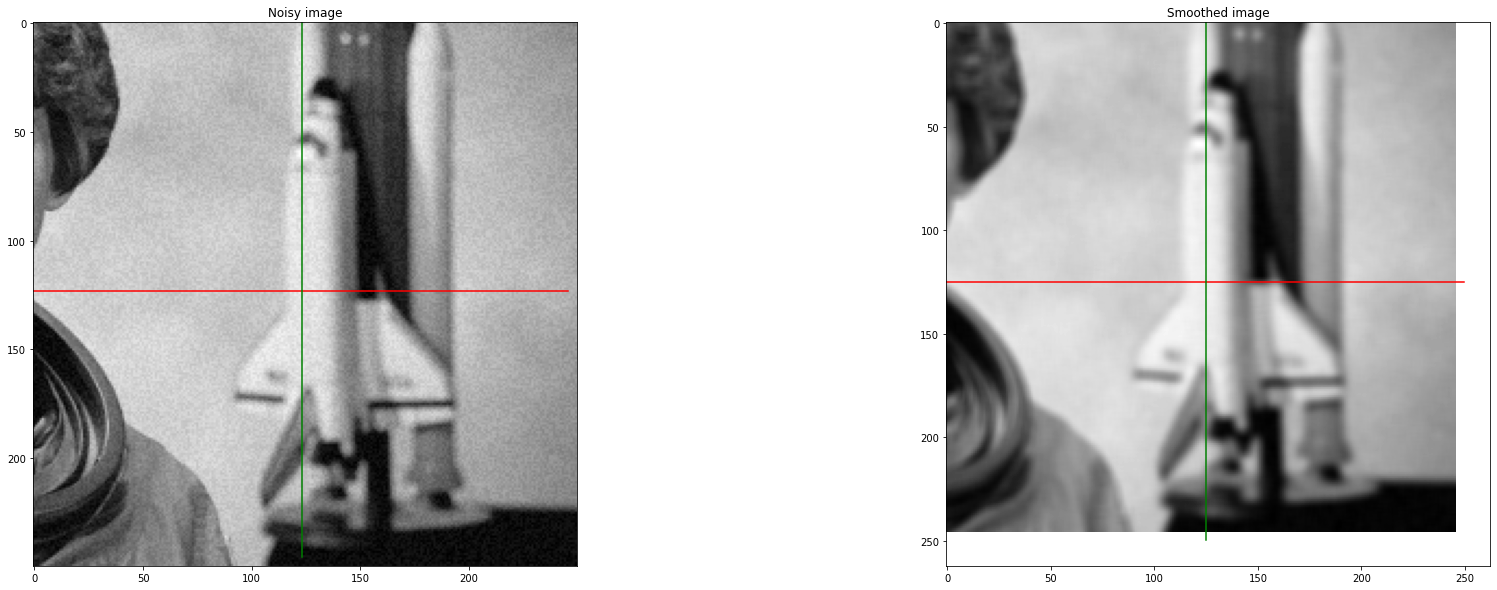

In [12]:
import torch.nn.functional as F

h, w = x_gray.shape
k_h, k_w = kernel.shape
x_smooth = F.conv2d(x_gray.view(1, 1, h, w), kernel.view(1, 1, k_h, k_w)).squeeze()
h, w = x_smooth.shape

plt.rcParams['figure.figsize'] = [15, 5]
plt.subplot(1, 2, 2)
plt.title('Filter response')
plt.plot(x_smooth[:, w//2], 'g')

plt.subplot(1, 2, 1)
plt.title('Filter response')
plt.plot(x_smooth[h//2, :], 'r')
plt.show()


plt.rcParams['figure.figsize'] = [30, 10]

plt.subplot(1, 2, 1)
plt.title('Noisy image')
plt.imshow(x_gray, cmap='gray')
plt.plot([-0.5, w-0.5], [h/2, h/2], "r")
plt.plot([w/2, w/2], [-0.5, h-0.5], "g")
plt.subplot(1, 2, 2)
plt.title('Smoothed image')
plt.imshow(x_smooth, cmap='gray')
plt.plot([-0.5, (w+k_w-1)-0.5], [(h+k_h-1)/2, (h+k_h-1)/2], "r")
plt.plot([(w+k_w-1)/2, (w+k_w-1)/2], [-0.5, (h+k_h-1)-0.5], "g")
plt.show()


_Modify the values of the kernel to see the effect on the convolution response_

In [30]:
kernel = torch.FloatTensor([
    [0, 1, 0], 
    [0, 0, 0], 
    [0, -1, 0]
])

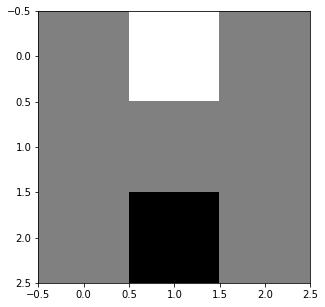

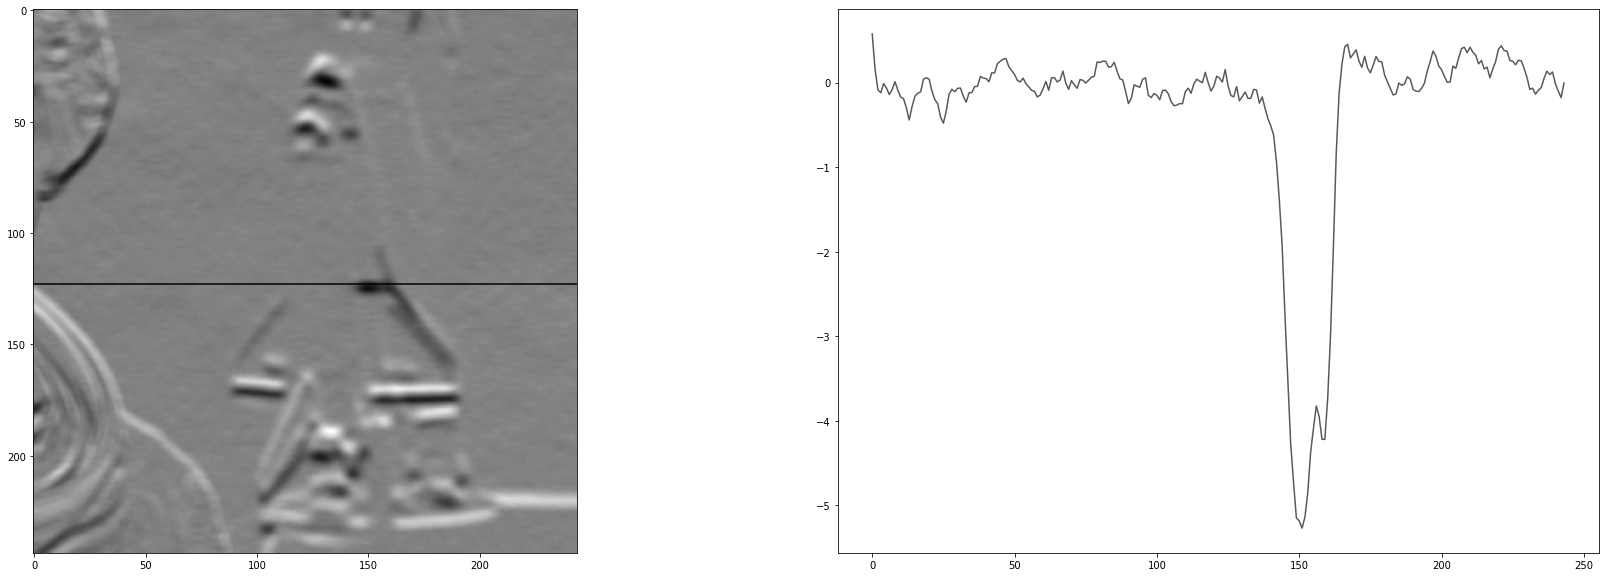

In [31]:
import torch.nn.functional as F

h, w = x_smooth.shape
k_h, k_w = kernel.shape
res = F.conv2d(x_smooth.view(1, 1, h, w), kernel.view(1, 1, k_h, k_w)).squeeze()

plt.rcParams['figure.figsize'] = [15, 5]
plt.imshow(kernel, cmap='gray')
plt.show()

plt.rcParams['figure.figsize'] = [30, 10]

plt.subplot(1, 2, 1)
plt.imshow(res, cmap='gray')
plt.plot([-0.5, w-2.5], [h/2, h/2], "k")
plt.subplot(1, 2, 2)
plt.plot(res[h//2, :], c='0.35')
plt.show()

More on filters and convolutions can be found [here](https://petebankhead.gitbooks.io/imagej-intro/content/chapters/filters/filters.html#sec-filters_linear_general).


![Image](https://pytorch.org/tutorials/_images/mnist.png)

The first layer applies **six** $5\times5$ linear kernels over every pixel of the input image.<br>

In [36]:
import torch
import torch.nn as nn # Short for Neural Netowrk

In [35]:
conv_1 = nn.Conv2d(
    in_channels=1, # Because the input image is grayscale
    out_channels=6, # to generate six new feature maps / channels
    kernel_size=5,
    stride=1, # to pass the kernel filters over each pixel of the image
    padding=0, # do not add padding to the image edges (this will reduce the size of the output)
    bias=False # do not add a bias intercept to the output of this layer
)

In [37]:
conv_1 = nn.Conv2d(
    in_channels=1, # Because the input image is grayscale
    out_channels=6, # to generate six new feature maps / channels
    kernel_size=5
)

_More details of the available parameters to create a two dimensional convolutional layer can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d)_

In [38]:
conv_1

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))

In [39]:
print(conv_1.weight.size())
print(conv_1.weight)

torch.Size([6, 1, 5, 5])
Parameter containing:
tensor([[[[ 0.0760,  0.0914,  0.1795, -0.0950,  0.0147],
          [ 0.1893,  0.1609,  0.0278, -0.1744,  0.0069],
          [ 0.0989,  0.1638,  0.0771,  0.0725, -0.0604],
          [-0.1510,  0.1173,  0.1851, -0.0336, -0.0396],
          [ 0.1947,  0.0525, -0.1623, -0.0984, -0.0331]]],


        [[[ 0.0929,  0.0467,  0.1277,  0.1658, -0.1457],
          [-0.0316,  0.0351,  0.1342, -0.1783,  0.1812],
          [ 0.1454, -0.1092, -0.0957,  0.1099, -0.0660],
          [ 0.1908, -0.0491,  0.1047,  0.1302, -0.0079],
          [-0.0853,  0.0136,  0.0994,  0.1856, -0.1005]]],


        [[[-0.0704, -0.0530, -0.1647, -0.0656,  0.1658],
          [ 0.0707, -0.0210,  0.1963, -0.1308, -0.1903],
          [-0.0433, -0.0926, -0.1260, -0.0221,  0.0052],
          [ 0.0350, -0.1955, -0.0878,  0.0694, -0.1606],
          [ 0.0639, -0.1014,  0.1128,  0.1085, -0.0394]]],


        [[[-0.1145, -0.0861, -0.1218, -0.1507,  0.0038],
          [ 0.0707,  0.1250, 

Because we defined *conv_1* using a **nn.Module**, the operation will track the gradients for the weights and bias of that operation.<br>
Those weights and bias are kwnown as the *learnable parameters*.<br>
By default, bias is always added to linear and convolution operations.<br>
This single layer has $6\times1\times5\times 5 = 150$ parameters.

***
The following operation applied to the first convolution layer is a ReLU activation function.<br>
These functions can be found also inside the PyTorch's *nn* module (follow this [link](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) to see the different activation functions available).

In [9]:
act_1 = nn.ReLU()

In [10]:
act_1

ReLU()

***
The subsampling operation (S2 in the LeNet's illustration) is implemented by a *max pooling* operation.

In [11]:
sub_1 = nn.MaxPool2d(
    kernel_size=2,
    stride=2,
    padding=0
)

In [11]:
sub_1 = nn.MaxPool2d(
    kernel_size=2,
    stride=2
)

In [12]:
sub_1

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

***
Depending the task, the last layers of a network will be used to abstract the spatial information into a one-dimensional representation.
This is achieved by *flattening* the tensor into a *vector*, to perform linear operations (matrix-vector).
These layers are known as **Fully Connected** (FC), and are implemented by multilayer perceptrons.

In [15]:
fc_1 = nn.Linear(
    in_features=16*5*5, 
    out_features=120, 
    bias=True
)

In [16]:
fc_1

Linear(in_features=400, out_features=120, bias=True)

***
## 3.2 _Neural network inputs_

PyTorch modules expect the inputs to be in the shape of *batch size* $\times$ *input channels* $\times$ *height* $\times$ *width* 

In [56]:
x = torch.rand((7, 1, 32, 32))

Modules defined from the *nn* module have a built-in *forward* function.
The default behavior of nn modules when called is to use their correspondig *forward* function.

In [57]:
fx = conv_1(x)

In [58]:
fx.size()

torch.Size([7, 6, 28, 28])

In the LeNet's architecture illustration, the output of the first convolution layer (C1) are six feature maps of size $28\times28$.

![Image](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)<br>
_Source: Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning (2016)_

![Image](https://pytorch.org/tutorials/_images/mnist.png)

***
The next operation is a ReLU activation function that is applied element-wise to each element of the tensor.

In [21]:
fx = act_1(fx)

In [48]:
fx.size()

torch.Size([1, 6, 28, 28])

***
The subsampling operation is applied using a kernel of size $2\times2$, and is applied every $2$ pixels, resulting on a feature map with half the size of the input tensor.

In [24]:
fx = sub_1(fx)

In [25]:
fx.size()

torch.Size([1, 6, 14, 14])

Now, the feature maps have a size of $14\times14$, just as illustrated in the LeNet's architecture.

***

## 3.3 _Defining a neural network architecture as a python class_

PyTorch provides a *pythonic* framework to develop neural networks.
For that reason, architectures are defined as classes derived from the **nn.Module** class.<br>
A class defining an neural network architecture is rquired to call the nn.Module initialization function and implement a **forward** function.

![Image](https://pytorch.org/tutorials/_images/mnist.png)

Fully connected layers are a fancy name for Multilayer perceptrons

In [150]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        """
        Always call the initialization function from the nn.Module parent class.
        This way all parameters from the operations defined as members of *this* class are tracked for their optimization.
        """
        super(LeNet, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.sub_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.sub_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc_2 = nn.Linear(in_features=120, out_features=84)
        self.fc_3 = nn.Linear(in_features=84, out_features=num_classes)
        
        self.act_fn = nn.ReLU()

    def forward(self, x):
        # Apply convolution layers to extract feature maps with image context
        fx = self.act_fn(self.conv_1(x))
        fx = self.sub_1(fx)
        
        fx = self.act_fn(self.conv_2(fx))
        fx = self.sub_2(fx)
        
        # Flatten the feature maps to perform linear operations
        fx = fx.view(-1, 16*5*5)
        
        fx = self.act_fn(self.fc_1(fx))
        fx = self.act_fn(self.fc_2(fx))
        y = self.fc_3(fx)
        
        return y

In [64]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(LeNet, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.sub_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.sub_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc_2 = nn.Linear(in_features=120, out_features=84)
        self.fc_3 = nn.Linear(in_features=84, out_features=num_classes)
        
        self.act_fn = nn.ReLU()
        
    def forward(self, x):
        fx = self.conv_1(x)
        fx = self.act_fn(fx)
        fx = self.sub_1(fx)
        
        fx = self.conv_2(fx)
        fx = self.act_fn(fx)
        fx = self.sub_2(fx)
        
        fx = fx.view(-1, 16*5*5)
        
        fx = self.fc_1(fx)
        fx = self.act_fn(fx)
        
        fx = self.fc_2(fx)
        fx = self.act_fn(fx)
        
        fx = self.fc_3(fx)
        
        return fx
        

In [65]:
net = LeNet(in_channels=1, num_classes=10)

In [66]:
print(net)

LeNet(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (sub_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sub_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (act_fn): ReLU()
)


In [67]:
print(x.size())

torch.Size([7, 1, 32, 32])


In [68]:
y = net(x)

In [69]:
print(y.size())

torch.Size([7, 10])


In [70]:
print(y)

tensor([[-0.0031,  0.0048, -0.0113,  0.0442,  0.0215,  0.0932, -0.0678, -0.0862,
         -0.0197, -0.0383],
        [ 0.0062,  0.0022, -0.0095,  0.0357,  0.0371,  0.0869, -0.0728, -0.0889,
         -0.0132, -0.0387],
        [-0.0050,  0.0047, -0.0121,  0.0318,  0.0215,  0.0824, -0.0624, -0.0800,
         -0.0176, -0.0368],
        [-0.0067,  0.0007, -0.0110,  0.0255,  0.0175,  0.0845, -0.0734, -0.0890,
         -0.0138, -0.0369],
        [-0.0014, -0.0003, -0.0090,  0.0305,  0.0188,  0.0934, -0.0672, -0.0864,
         -0.0156, -0.0413],
        [ 0.0036,  0.0009, -0.0061,  0.0319,  0.0226,  0.0939, -0.0655, -0.0870,
         -0.0201, -0.0332],
        [-0.0094,  0.0091, -0.0009,  0.0329,  0.0262,  0.0835, -0.0694, -0.0836,
         -0.0185, -0.0369]], grad_fn=<AddmmBackward0>)


In [71]:
print(y.softmax(dim=1))

tensor([[0.1002, 0.1010, 0.0994, 0.1050, 0.1027, 0.1103, 0.0939, 0.0922, 0.0985,
         0.0967],
        [0.1010, 0.1006, 0.0995, 0.1041, 0.1042, 0.1095, 0.0934, 0.0919, 0.0991,
         0.0966],
        [0.1001, 0.1011, 0.0994, 0.1039, 0.1028, 0.1093, 0.0946, 0.0929, 0.0989,
         0.0970],
        [0.1002, 0.1010, 0.0998, 0.1035, 0.1027, 0.1098, 0.0938, 0.0923, 0.0995,
         0.0973],
        [0.1005, 0.1006, 0.0998, 0.1038, 0.1026, 0.1105, 0.0941, 0.0923, 0.0991,
         0.0966],
        [0.1008, 0.1006, 0.0999, 0.1037, 0.1028, 0.1104, 0.0941, 0.0921, 0.0985,
         0.0972],
        [0.0996, 0.1015, 0.1005, 0.1039, 0.1032, 0.1093, 0.0938, 0.0925, 0.0987,
         0.0969]], grad_fn=<SoftmaxBackward0>)


In [72]:
print(y.softmax(dim=1).sum(dim=1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


In [75]:
total_parameters = 0
for par in net.parameters():
    total_parameters += torch.numel(par)

In [76]:
total_parameters

61706